# Characterizing a Single-Species Graph
The purpose of this notebook is to characterize the dataset of genes, phenotypes, and annotations for Arabidopsis thaliana specifically. The sources of information include several different resources which are aggregated at differnet points in the analysis, and specified below. We want to figure out what kinds of properties the different graphs have in terms of potential predictive power for untangling pathway interactions or predicting pathway membership of regulatory network clusters. This is done for the purposes of figuring out if the predictions made over text descriptions that do *not* have the corresponding high-quality annotations or characterizations are likely to be useful to biologists.

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time
import math
import sys
import gensim
import os
import warnings
import itertools
from collections import Counter
from inspect import signature
from scipy.stats import ks_2samp

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

sys.path.append("../../oats")
from oats.utils.utils import save_to_pickle, load_from_pickle, merge_list_dicts
from oats.utils.utils import function_wrapper, to_hms
from oats.datasets.dataset import Dataset
from oats.datasets.groupings import Groupings
from oats.datasets.string import get_stringdb_information
from oats.annotation.ontology import Ontology
from oats.annotation.annotation import write_annotations_to_tsv_file, read_annotations_from_tsv_file
from oats.graphs.pairwise import pairwise_edgelist_doc2vec, pairwise_edgelist_bagofwords, pairwise_edgelist_setofwords
from oats.graphs.pairwise import pairwise_edgelist_annotations, merge_edgelists, subset_edgelist_with_ids
from oats.objectives.functions import balance_classes

warnings.simplefilter('ignore')

## Does the graph recapitulate known protein-protein interactions?
The different sections in this notebook correspond to different ways of determining if the graphs based on similarity between text descriptions, encodings of text descriptions, or annotations derived from text descriptions at all correspond to known protein-protein interactions in this dataset. The knowledge source about the protein-protein interactions for genes in this dataset is the STRING database (https://string-db.org/). The available entries in the whole dataset are subset to include only the genes that correspond to proteins that are atleast mentioned in the STRING database. This ways if a protein-protein interaction is not specified between two of the remaining genes, it is not because no interactions at all are documented either of those genes. The following cells focus on setting up a dataframe which specifies edge lists specific to each similarity method, and also a protein-protein interaction score for the genes which correspond to those two given nodes in the graphs.

In [55]:
# This dataset is only focused on including all genes mapped to some text information.
dataset = Dataset()
dataset.add_data(pd.read_csv("../data/reshaped_files/ath_tair_gene_text.csv", lineterminator="\n"))
dataset.add_data(pd.read_csv("../data/reshaped_files/all_pppn_gene_textlong_annot.csv", lineterminator="\n"))
dataset.add_data(pd.read_csv("../data/reshaped_files/all_pppn_gene_textshort_annot.csv", lineterminator="\n"))
dataset.filter_by_species(["ath"])
dataset.filter_random_k(100, seed=19824)
dataset.collapse_by_all_gene_names()
dataset.describe()

Number of rows in the dataframe: 98
Number of unique IDs:            98
Number of unique descriptions:   95
Number of unique gene name sets: 98
Number of species represented:   1


In [56]:
# Reduce size of the dataset by removing genes not mentioned in the STRING.
string_database_file = "/Users/irbraun/Downloads/3702.protein.links.detailed.v11.0.txt"
string_df, string_id_list = get_stringdb_information(string_database_file, dataset.get_name_to_id_dictionary())
dataset.filter_with_ids(string_id_list)
dataset.describe()

Number of rows in the dataframe: 29
Number of unique IDs:            29
Number of unique descriptions:   29
Number of unique gene name sets: 29
Number of species represented:   1


In [102]:
# Setup some of the preliminary ontology, embedding, and datset objects.
doc2vec_model_filename = "../gensim/enwiki_dbow/doc2vec.bin"
doc2vec_model = gensim.models.Doc2Vec.load(doc2vec_model_filename)
descriptions = dataset.get_description_dictionary()

# Construct the graphs based on similarity between the text associated with each gene.
name_to_df_mapping = {}
name_to_df_mapping["doc2vec"] = pairwise_edgelist_doc2vec(doc2vec_model, descriptions)
name_to_df_mapping["bagofwords"] = pairwise_edgelist_bagofwords(descriptions) 
name_to_df_mapping["setofwords"] = pairwise_edgelist_setofwords(descriptions)
df = merge_edgelists(name_to_df_mapping, default_value=0.000)
print(df.head(5))
print(df.shape)

   from  to   doc2vec  bagofwords  setofwords
0     0   0  0.000000    0.000000    0.000000
1     0   1  0.441946    0.882149    0.937500
2     0   2  0.438640    0.676425    0.882353
3     0   3  0.468062    1.000000    1.000000
4     0   4  0.443751    1.000000    1.000000
(435, 5)


In [103]:
# Merging information from the protein-protein interaction database with this data.
df = df.merge(right=string_df, how="left", on=["from","to"])
df.fillna(value=0,inplace=True)
print(df.head(5))
print(df.shape)

   from  to   doc2vec  bagofwords  setofwords  combined_score
0     0   0  0.000000    0.000000    0.000000             0.0
1     0   1  0.441946    0.882149    0.937500             0.0
2     0   2  0.438640    0.676425    0.882353             0.0
3     0   3  0.468062    1.000000    1.000000             0.0
4     0   4  0.443751    1.000000    1.000000             0.0
(435, 6)


### 1.1 Do the edges joining interacting proteins come from a different distribution?
This section uses a statistical test (Kolmogorov-Smirnov) to see if the distributions of edge weights which correspond to edges representing a known protein interaction come drom a different distribution than the edge weights for edges that do not. This test was chosen because the sizes of the two samples can be different and there is no assumption of normality for the underlying distributions.

In [104]:
METHOD_NAMES = ["doc2vec", "bagofwords", "setofwords"]

In [105]:
# Use KS test to see if protein-protein interaction edges come from a unique distribution.
ppi_pos_dict = {name:(df[df["combined_score"] > 0.00][name].values) for name in METHOD_NAMES}
ppi_neg_dict = {name:(df[df["combined_score"] == 0.00][name].values) for name in METHOD_NAMES}
results = {}
for name in METHOD_NAMES:
    stat,p = ks_2samp(ppi_pos_dict[name],ppi_neg_dict[name])
    pos_mean = np.average(ppi_pos_dict[name])
    neg_mean = np.average(ppi_neg_dict[name])
    pos_n = len(ppi_pos_dict[name])
    neg_n = len(ppi_neg_dict[name])
    results[name] = {"pos_mean":pos_mean, "neg_mean":neg_mean, "pos_n":pos_n, "neg_n":neg_n, "D": stat, "p_value":p}  

print(pd.DataFrame(results).transpose())

            pos_mean  neg_mean  pos_n  neg_n         D   p_value
doc2vec     0.402857  0.393334    8.0  427.0  0.171253  0.945861
bagofwords  0.969822  0.854495    8.0  427.0  0.344848  0.244219
setofwords  0.986324  0.901129    8.0  427.0  0.344848  0.244219


### 1.2 What do those distributions of edge weights in the graph look like?
The distributions of the samples are distinct enough for some of the similarity metrics that the KS tests are significant, where the mean distance between nodes connected by edges which correspond to real protein-protein interactions is lower than for those that do not. In the next cell the density plots of those distributions are visualized. The red distributions are edges that were not found to correspond to known protein-protein interactions, and the green distributions are for edges that do correspond to known protein-protein interactions.

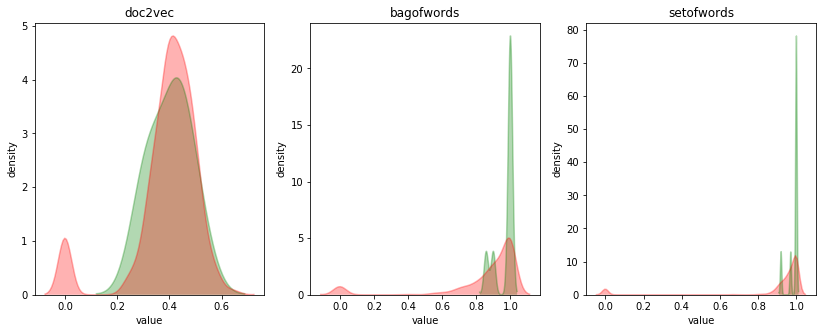

In [72]:
fig, axs = plt.subplots(1,len(METHOD_NAMES))
for col,ax in zip(METHOD_NAMES,axs):
    ax.set_title(col)
    ax.set_xlabel("value")
    ax.set_ylabel("density")
    sns.kdeplot(ppi_pos_dict[col], color="green", shade=True, alpha=0.3, ax=ax)
    sns.kdeplot(ppi_neg_dict[col], color="red", shade=True, alpha=0.3, ax=ax) 
fig.set_size_inches(14.0, 5.0)
fig.show()

### 1.3 Can we practically use the graph to predict known protein-protein interactions?
This is a different question than above, because the false positive rate is a limiting factor in how practically useful it would be to generate predictions about real protein interactions. In the case of the statistical test above, the sample distribution could be significantly different than the whole distribution of edge values even if there are many high valued edges which look like they could come from the sample distribution (i.e., the sample distribution could be distinct because of a *lack* of low values, not there could still be many high values that aren't positive edges in this cases, which will be false positives).

In [73]:
# Class ratio of negative over positive, set arbitrary large to effectively do no balancing.
CLASS_RATIO = 3**10

In [75]:
# Providing summary statistics for precision recall curve using graph directly.
y_true_dict = {name:(np.where(df["combined_score"] > 0.000, 1, 0)) for name in METHOD_NAMES}
y_prob_dict = {name:(1 - df[name].values) for name in METHOD_NAMES}
results = {}
for name in METHOD_NAMES:
    y_true, y_prob = y_true_dict[name], y_prob_dict[name]
    y_true, y_prob = balance_classes(y_true, y_prob, CLASS_RATIO)
    n_pos, n_neg = Counter(y_true)[1], Counter(y_true)[0]
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    baseline = Counter(y_true)[1]/len(y_true) 
    average_precision = average_precision_score(y_true, y_prob)
    area = auc(recall, precision)
    auc_to_baseline_auc_ratio = area/baseline
    results[name] = {"auc":area, "baseline":baseline, "num_pos":n_pos, "num_neg":n_neg}
    
print(pd.DataFrame(results).transpose())

                 auc  baseline  num_pos  num_neg
doc2vec     0.019573  0.018391      8.0    427.0
bagofwords  0.011483  0.018391      8.0    427.0
setofwords  0.011497  0.018391      8.0    427.0


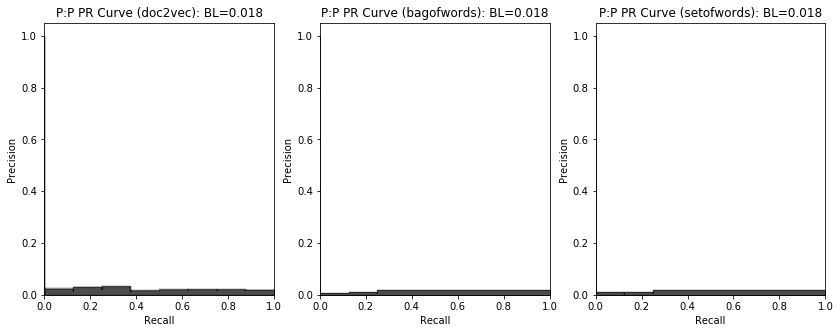

In [77]:
# Visualizing the precision recall curves for each method of estimating edge weight.
fig, axs = plt.subplots(1,len(METHOD_NAMES))
for method,ax in zip(METHOD_NAMES,axs):
    y_true, y_prob = y_true_dict[method], y_prob_dict[method]
    y_true, y_prob = balance_classes(y_true, y_prob, CLASS_RATIO)
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    baseline = Counter(y_true)[1]/len(y_true) 
    step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})
    ax.step(recall, precision, color='black', alpha=0.2, where='post')
    ax.fill_between(recall, precision, alpha=0.7, color='black', **step_kwargs)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    ax.set_title("P:P PR Curve ({0}): BL={1:0.3f}".format(method, baseline))
    
fig.set_size_inches(14.0, 5.0)
fig.show()

### 1.4 Is there evidence that querying the graph with one gene will successfully return a gene that it interacts with?
Explain what we mean by querying, and more in-depth description of what we're trying to find out here with these tests.

In [99]:
# Get the list of gene IDs involved in interation with atleast one other protein in this dataset.
genes_with_partners = pd.unique(string_df[["from","to"]].dropna().values.ravel('K'))
partner_ranks_dict = {}

# For each method, obtain a list of the rankings in terms of similarity as measured by that method, using each gene
# iteratively as the query gene. The method of accessing the ranks is to first subset the edgelist dataframe to 
# contain only the rows where an edge involving the node of the query gene is specified, then the edge list is 
# sorted by the specific similarity score for that method, so that the indices of edges where the protein-protein
# interaction score is non-zero will correspond directly to ranks.
for name in METHOD_NAMES:
    partner_ranks = []
    for gene_id in genes_with_partners:
        merged_df = pd.concat([df[df["from"]==gene_id],df[df["to"]==gene_id]],ignore_index=True)
        merged_df = merged_df.sort_values(by=[name]).reset_index(drop=True)
        indices = merged_df.query("combined_score > 0.00").index.tolist()
        partner_ranks.extend(indices)
    partner_ranks = [rank+1 for rank in partner_ranks]
    partner_ranks_dict[name] = partner_ranks
    print("{0:<14}{1:}".format(name,len(partner_ranks)))

doc2vec       16
bagofwords    16
setofwords    16


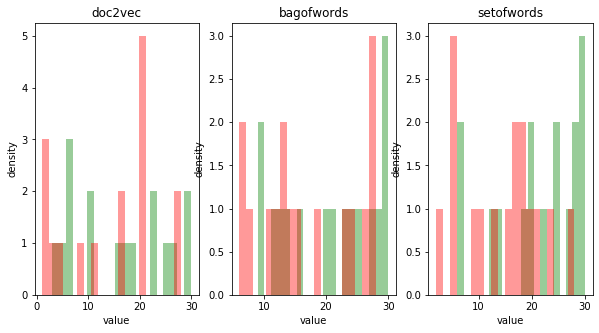

In [101]:
max_rank = len(pd.unique(df[["from","to"]].dropna().values.ravel('K')))
num_bins = 20
fig, axs = plt.subplots(1,len(METHOD_NAMES))
for name,ax in zip(METHOD_NAMES,axs):
    partner_ranks = partner_ranks_dict[name]
    random_ranks = np.random.choice(np.arange(max_rank), len(partner_ranks))
    random_ranks = [r+1 for r in random_ranks]
    ax.set_title(name)
    ax.set_xlabel("value")
    ax.set_ylabel("density")
    sns.distplot(partner_ranks, bins=num_bins, color="green", kde=False, ax=ax)
    sns.distplot(random_ranks, bins=num_bins, color="red", kde=False, ax=ax) 

fig.set_size_inches(10.0, 5.0)
fig.show()